In [5]:
%pip install -q ../introdl

    torch (>=1.9.*)
           ~~~~~~^
Note: you may need to restart the kernel to use updated packages.


# Advanced

* Early Stopping
* Batch Normalization (and Layer Normalization)
* Residual Connections (and Skip Connections)
* Transfer Learning

In [2]:
# configuration
data_dir = '../../data' # directory to save data - change as needed

In [3]:
# imports

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

sns.set_theme(style='whitegrid')

plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

from sklearn.metrics import accuracy_score

from torchinfo import summary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

from introdl.utils import get_device, load_results, summarizer
from introdl.idlmam import train_network
from introdl.visul import show_image_grid, plot_training_metrics

## Early Stopping

Training for too long can cause overfitting.  One way to avoid this is to add an early stopping strategy to the training loop.  To do that, monitor the loss or another metric on a validation (or test) data set and if that metric doesn't improve for some number of iterations (called the 'patience'), then training is stopped.  Below is a code snippet to show what this could look like:

```python
best_loss = float('inf')
patience = 5
no_improvement = 0

for epoch in range(epochs):
    # Training code here
    
    # Validation code here
    val_loss = calculate_validation_loss(model, val_loader)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        
    if no_improvement >= patience:
        print("Early stopping: No improvement in validation loss for {} epochs".format(patience))

        break
```

## Going Deeper

Our results in Lesson 3 for CIFAR-10 classification weren't amazing.  Our models had relatively few layers and managed to attain about 70% accuracy on the validation set.  CIFAR-10 is a challenging dataset because there is a lot of variation between the images within each class.  One way to tackle this complexity is to add more layers to our network.  For example here is a model that includes a thirteen convolutional layers separated by activation functions.  We didn't include any pooling layers here, but instead used some convolution layers with stride=2 to reduce the dimensions of the feature maps.  

The code for our model is in the next cell.  Don't worry about trying to understand every bit of the code for now.  Just focus on the overall construction of a deeper model.  The model in this case has 13 convolutional layers.  That's deeper than anything we've built so far, but is relatively shallow compared to many modern CNNs.

In [6]:
class BasicBlock(nn.Module):
    """Basic Block for Plain CNN without Batch Normalization."""
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # No batch normalization layers

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        return out

class PlainCNN(nn.Module):
    """Plain CNN without residual connections and batch normalization for CIFAR-10."""
    def __init__(self, block, num_blocks, num_classes=10):
        super(PlainCNN, self).__init__()
        self.in_planes = 16
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # No batch normalization layer

        # Layers
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        # Fully connected layer
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        """Create a layer without residual connections and batch normalization."""
        layers = []
        strides = [stride] + [1]*(num_blocks - 1)
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolutional block
        out = F.relu(self.conv1(x))
        # Layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # Global average pooling and classifier
        out = F.avg_pool2d(out, out.size(3))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DeeperCNNCIFAR10():
    """Constructs a Plain CNN model without batch normalization for CIFAR-10."""
    return PlainCNN(BasicBlock, [2, 2, 2], num_classes=10)


In [7]:
model = DeeperCNNCIFAR10()

summarizer(model, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
PlainCNN                                 [64, 3, 32, 32]      [64, 10]             --
├─Conv2d: 1-1                            [64, 3, 32, 32]      [64, 16, 32, 32]     432
├─Sequential: 1-2                        [64, 16, 32, 32]     [64, 16, 32, 32]     --
│    └─BasicBlock: 2-1                   [64, 16, 32, 32]     [64, 16, 32, 32]     --
│    │    └─Conv2d: 3-1                  [64, 16, 32, 32]     [64, 16, 32, 32]     2,304
│    │    └─Conv2d: 3-2                  [64, 16, 32, 32]     [64, 16, 32, 32]     2,304
│    └─BasicBlock: 2-2                   [64, 16, 32, 32]     [64, 16, 32, 32]     --
│    │    └─Conv2d: 3-3                  [64, 16, 32, 32]     [64, 16, 32, 32]     2,304
│    │    └─Conv2d: 3-4                  [64, 16, 32, 32]     [64, 16, 32, 32]     2,304
├─Sequential: 1-3                        [64, 16, 32, 32]     [64, 32, 16, 16]     --
│    └─BasicBlock: 2-3              

### Summary of Layers

The PlainCNN model without batch normalization consists of several layers organized into an initial convolutional layer, multiple convolutional blocks, downsampling layers, a global average pooling layer, and a fully connected layer. Below is a detailed summary of the number and types of layers in this model.

### **Key Points:**

- **Convolutional Layers:** Total of **13**.
- **Activation Functions (ReLU):** Total of **13**.
- **Downsampling:**
  - Achieved using convolutional layers with **stride=2** in the first block of **Layer 2** and **Layer 3**.
- **Pooling Layers:** Only one **global average pooling layer** at the end.
- **Fully Connected Layer:** Maps the features to the 10 CIFAR-10 classes.

---

### **Understanding the Model Architecture:**

- **Initial Convolutional Layer:**
  - Processes the input image and extracts basic features.
- **Convolutional Blocks:**
  - Each block consists of two convolutional layers with ReLU activations.
  - **Layer 1** processes features at the initial channel size (16 channels).
  - **Layer 2** increases the number of channels to 32 and reduces spatial dimensions.
  - **Layer 3** increases the number of channels to 64 and further reduces spatial dimensions.
- **Downsampling:**
  - Performed by convolutional layers with **stride=2** in the first block of Layers 2 and 3.
- **Global Average Pooling:**
  - Reduces each feature map to a single value, resulting in a feature vector.
- **Fully Connected Layer:**
  - Takes the feature vector and outputs class scores.



In [5]:
# Create CIFAR10 data loaders with augmentation as in Lesson 3

def create_CIFAR10_loaders(transform_train, transform_test, valid_prop=0.2, batch_size=64, seed=42):
    """
    Create data loaders for the CIFAR10 dataset.

    Args:
        transform_train (torchvision.transforms.Compose): A composition of transformations to apply to the training dataset.
        transform_test (torchvision.transforms.Compose): A composition of transformations to apply to the test dataset.
        valid_prop (float): The proportion of the training dataset to use for validation.
        seed (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        torch.utils.data.DataLoader: A data loader for the training dataset.
        torch.utils.data.DataLoader: A data loader for the validation dataset.
        torch.utils.data.DataLoader: A data loader for the test dataset.
    """

    # Set random seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Load the full dataset
    train_dataset_full = CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
    test_dataset = CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

    # Split the dataset into training and validation sets
    train_size = int((1 - valid_prop) * len(train_dataset_full))
    valid_size = len(train_dataset_full) - train_size
    train_dataset, valid_dataset = random_split(train_dataset_full, [train_size, valid_size])

    # Create data loaders (may want more workers on CUDA or CPU, but only 1 on MPS)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

    return train_loader, valid_loader, test_loader

# Mean and Std for CIFAR10 dataset
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)    
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_loader, valid_loader, test_loader = create_CIFAR10_loaders(transform_train, transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
model = DeeperCNNCIFAR10()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())  # default lr=0.001, weight_decay=0.01

device = get_device()
print(device)

ckpt_file = 'models/model_CIFAR10_DeeperCNN.pt'
epochs = 40

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                val_loader=valid_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file)

mps


Epoch: 100%|██████████| 10/10 [04:22<00:00, 26.28s/it]


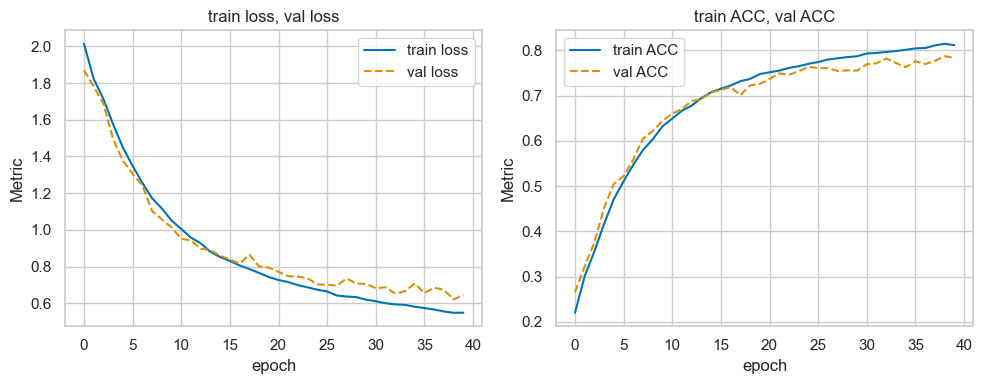

In [32]:
results = load_results('models/model_CIFAR10_DeeperCNN.pt')

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

## Batch Normalization

Batch normalization is a technique commonly used in deep learning models to improve the training process and the overall performance of the model. It addresses the problem of internal covariate shift, which refers to the change in the distribution of the input values to a layer during training. 

During the training process, as the parameters of the previous layers change, the distribution of the input to the current layer also changes. This makes it difficult for the subsequent layers to learn effectively, as they have to constantly adapt to the changing input distribution. This phenomenon slows down the training process and makes it harder for the model to converge.

Batch normalization helps to mitigate this problem by normalizing the input values to a layer. It calculates the mean and standard deviation of the input values within a mini-batch and then normalizes the values based on these statistics. This normalization step ensures that the input values have zero mean and unit variance.

By normalizing the input values, batch normalization helps to stabilize the training process. It reduces the internal covariate shift, making it easier for the subsequent layers to learn. Additionally, batch normalization acts as a regularizer, reducing the reliance on dropout or other regularization techniques.

Overall, batch normalization improves the training speed, allows for higher learning rates, and makes the model more robust to different input distributions. It has become a standard technique in deep learning models and is widely used in various architectures.

Below we update the `SimpleCNN` model to include batch normalization as discussed in the book.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlockwithBN(nn.Module):
    """Basic Block for Plain CNN (without residual connections)."""
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlockwithBN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # No shortcut connection as in ResNet

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

class PlainCNNwithBN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PlainCNNwithBN, self).__init__()
        self.in_planes = 16
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        # Layers
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        # Fully connected layer
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        """Create a layer without residual connections."""
        layers = []
        strides = [stride] + [1]*(num_blocks - 1)
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolutional block
        out = F.relu(self.bn1(self.conv1(x)))
        # Layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # Global average pooling and classifier
        out = F.avg_pool2d(out, out.size(3))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DeeperCNNCIFAR10withBN():
    """Constructs a Plain CNN model for CIFAR-10."""
    return PlainCNN(BasicBlockwithBN, [2, 2, 2], num_classes=10)

In [17]:
model = DeeperCNNCIFAR10withBN()

summarizer(model, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
PlainCNN                                 [64, 3, 32, 32]      [64, 10]             --
├─Conv2d: 1-1                            [64, 3, 32, 32]      [64, 16, 32, 32]     432
├─Sequential: 1-2                        [64, 16, 32, 32]     [64, 16, 32, 32]     --
│    └─BasicBlockwithBN: 2-1             [64, 16, 32, 32]     [64, 16, 32, 32]     --
│    │    └─Conv2d: 3-1                  [64, 16, 32, 32]     [64, 16, 32, 32]     2,304
│    │    └─BatchNorm2d: 3-2             [64, 16, 32, 32]     [64, 16, 32, 32]     32
│    │    └─Conv2d: 3-3                  [64, 16, 32, 32]     [64, 16, 32, 32]     2,304
│    │    └─BatchNorm2d: 3-4             [64, 16, 32, 32]     [64, 16, 32, 32]     32
│    └─BasicBlockwithBN: 2-2             [64, 16, 32, 32]     [64, 16, 32, 32]     --
│    │    └─Conv2d: 3-5                  [64, 16, 32, 32]     [64, 16, 32, 32]     2,304
│    │    └─BatchNorm2d: 3-6           

In [29]:
model = DeeperCNNCIFAR10withBN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())  # default lr=0.001, weight_decay=0.01

device = get_device()
print(device)

ckpt_file = 'models/model_CIFAR10_DeeperCNNwithBN.pt'
epochs = 40

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                val_loader=valid_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file)

mps


Epoch: 100%|██████████| 10/10 [04:59<00:00, 29.97s/it]


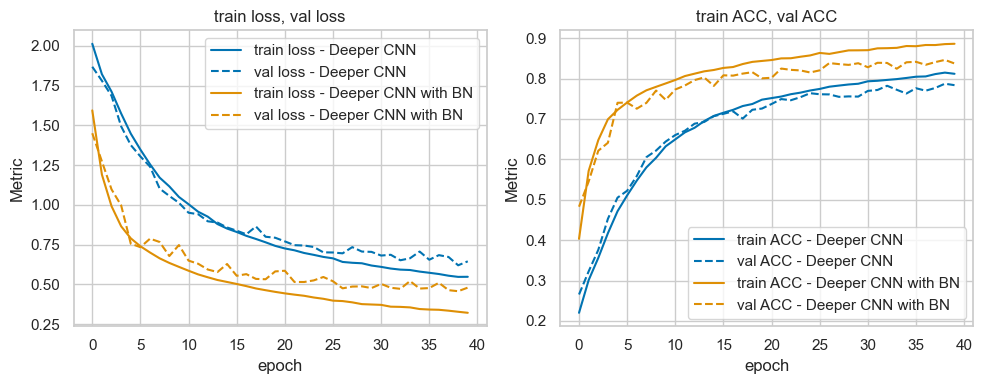

In [33]:
results = load_results('models/model_CIFAR10_DeeperCNN.pt')
resultsBN = load_results('models/model_CIFAR10_DeeperCNNwithBN.pt')

plot_training_metrics([results,resultsBN], [['train loss', 'val loss'], ['train ACC', 'val ACC']], df_labels=['Deeper CNN', 'Deeper CNN with BN'])

## Residual Connection

The idea of a residual connection is after passing an input through a layer and an activation the input is added to the result.  Why?  It turns out that this will make the loss surface smoother and easier to optimize. 

Nonlinear activation functions are the magic that make neural networks able to learn complex relationships, but they also make it difficult for neural network to model simple relationships.  The simplest relationship is the identity function - what goes in is what comes out.  

Let's set up a toy problem with a very simple network to see what the issue is.  We want the network to learn the identity function so that the outputs of the network match the inputs.  (The idea for this example comes from the book Step by Step, page 618)

We'll create 100 random data points with a single feature (just x values).  The labels are the same as the inputs.


In [12]:
torch.manual_seed(42)
toy_points = torch.randn((100, 1))
toy_dataset = TensorDataset(toy_points, toy_points)
toy_loader = DataLoader( toy_dataset, batch_size=16, shuffle=True)

In [36]:
class Toy(nn.Module): 
    def __init__(self):
        super(Toy, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        out = F.relu(self.linear(x))
        return out

In [37]:
model = Toy() # create a new instance, will be overwritten by the loaded model
loss_func = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())

device = torch.device('cpu')

ckpt_file = 'models/model_Toy.pt'
epochs = 100

results = train_network(model,
              loss_func,
              toy_loader,
              device=device,
              epochs = epochs,
              optimizer = optimizer,
              checkpoint_file=ckpt_file);

Epoch: 100%|██████████| 100/100 [00:00<00:00, 120.44it/s]


In [39]:
outputs = model(toy_points)
outputs = outputs.detach().numpy()
df = pd.DataFrame({'input':toy_points.squeeze(), 'output':outputs.squeeze()})
df

,input,output
0,1.926915,0.496521
1,1.487284,0.434713
2,0.900717,0.352249
3,-2.105521,0.000000
4,0.678418,0.320996
...,...,...
95,-0.303604,0.182935
96,-0.986439,0.086936
97,0.123299,0.242953
98,0.349868,0.274806


In [40]:
class ToyRes(nn.Module): 
    def __init__(self):
        super(ToyRes, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        out = F.relu(self.linear(x))
        return out+x

In [41]:
model = ToyRes() # create a new instance, will be overwritten by the loaded model
loss_func = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())

device = torch.device('cpu')

ckpt_file = 'models/model_ToyRes.pt'
epochs = 100

results = train_network(model,
              loss_func,
              toy_loader,
              device=device,
              epochs = epochs,
              optimizer = optimizer,
              checkpoint_file=ckpt_file);

Epoch: 100%|██████████| 100/100 [00:00<00:00, 132.47it/s]


In [42]:
outputs = model(toy_points)
outputs = outputs.detach().numpy()
dfRes = pd.DataFrame({'input':toy_points.squeeze(), 'output':outputs.squeeze()})
dfRes

,input,output
0,1.926915,2.035600
1,1.487284,1.487284
2,0.900717,0.900717
3,-2.105521,-2.105521
4,0.678418,0.678418
...,...,...
95,-0.303604,-0.303604
96,-0.986439,-0.986439
97,0.123299,0.123299
98,0.349868,0.349868


## Mini ResNet

In [13]:
class BasicBlock(nn.Module):
    """A basic block for ResNet with two convolutional layers and a residual connection."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer with batch normalization
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolutional layer with batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection for matching dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Apply the two convolutional layers
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection (residual)
        out += self.shortcut(x)
        # Apply ReLU again after adding the shortcut
        out = F.relu(out)
        return out


class MiniResNet(nn.Module):
    """A simplified ResNet-like model for CIFAR-10."""
    def __init__(self, num_classes=10):
        super(MiniResNet, self).__init__()
        self.in_channels = 16

        # Initial convolutional layer with batch normalization
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Residual layers
        self.layer1 = self._create_layer(BasicBlock, 16, 2, stride=1)
        self.layer2 = self._create_layer(BasicBlock, 32, 2, stride=2)
        self.layer3 = self._create_layer(BasicBlock, 64, 2, stride=2)

        # Fully connected layer for classification
        self.fc = nn.Linear(64, num_classes)

    def _create_layer(self, block, out_channels, num_blocks, stride):
        """Helper function to create a residual layer."""
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution + batch norm + ReLU
        out = F.relu(self.bn1(self.conv1(x)))

        # Pass through the residual blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        # Global average pooling
        out = F.avg_pool2d(out, out.size(3))
        out = out.view(out.size(0), -1)

        # Output layer
        out = self.fc(out)
        return out


def MiniResNetCIFAR10():
    """Function to create the MiniResNet model for CIFAR-10."""
    return MiniResNet(num_classes=10)


In [14]:
model = MiniResNetCIFAR10()

summarizer(model, input_size = (64,3,32,32))

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
MiniResNet                               [64, 3, 32, 32]      [64, 10]             --
├─Conv2d: 1-1                            [64, 3, 32, 32]      [64, 16, 32, 32]     432
├─BatchNorm2d: 1-2                       [64, 16, 32, 32]     [64, 16, 32, 32]     32
├─Sequential: 1-3                        [64, 16, 32, 32]     [64, 16, 32, 32]     --
│    └─BasicBlock: 2-1                   [64, 16, 32, 32]     [64, 16, 32, 32]     --
│    │    └─Conv2d: 3-1                  [64, 16, 32, 32]     [64, 16, 32, 32]     2,304
│    │    └─BatchNorm2d: 3-2             [64, 16, 32, 32]     [64, 16, 32, 32]     32
│    │    └─Conv2d: 3-3                  [64, 16, 32, 32]     [64, 16, 32, 32]     2,304
│    │    └─BatchNorm2d: 3-4             [64, 16, 32, 32]     [64, 16, 32, 32]     32
│    │    └─Sequential: 3-5              [64, 16, 32, 32]     [64, 16, 32, 32]     --
│    └─BasicBlock: 2-2                   [

In [14]:
model = MiniResNetCIFAR10()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())  # default lr=0.001, weight_decay=0.01

device = get_device()
print(device)

ckpt_file = 'models/model_CIFAR10_MiniResNet.pt'
epochs = 40

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                val_loader=valid_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file)

mps


Epoch: 100%|██████████| 20/20 [10:13<00:00, 30.70s/it]


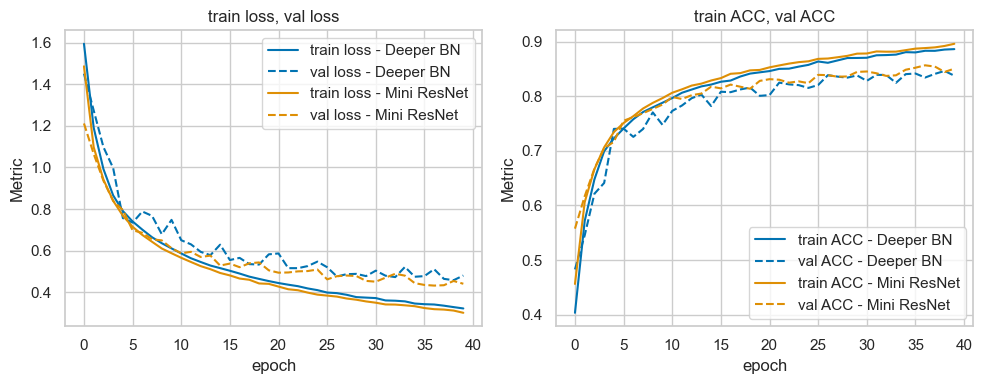

In [34]:
resultsBN = load_results('models/model_CIFAR10_DeeperCNNwithBN.pt')
resultsRES = load_results('models/model_CIFAR10_MiniResNet.pt')

plot_training_metrics([resultsBN,resultsRES], [['train loss', 'val loss'], ['train ACC', 'val ACC']],df_labels=['Deeper BN','Mini ResNet'])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeeperCNN2(nn.Module):
    def __init__(self, num_classes=10):
        super(DeeperCNN2, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Second Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Third Convolutional Block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        
        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)

        # Flattening
        x = x.view(-1, 256 * 4 * 4)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [7]:
# Create CIFAR10 data loaders with augmentation as in Lesson 3

def create_CIFAR10_loaders(transform_train, transform_test, valid_prop=0.2, batch_size=64, seed=42):
    """
    Create data loaders for the CIFAR10 dataset.

    Args:
        transform_train (torchvision.transforms.Compose): A composition of transformations to apply to the training dataset.
        transform_test (torchvision.transforms.Compose): A composition of transformations to apply to the test dataset.
        valid_prop (float): The proportion of the training dataset to use for validation.
        seed (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        torch.utils.data.DataLoader: A data loader for the training dataset.
        torch.utils.data.DataLoader: A data loader for the validation dataset.
        torch.utils.data.DataLoader: A data loader for the test dataset.
    """

    # Set random seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Load the full dataset
    train_dataset_full = CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
    test_dataset = CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

    # Split the dataset into training and validation sets
    train_size = int((1 - valid_prop) * len(train_dataset_full))
    valid_size = len(train_dataset_full) - train_size
    train_dataset, valid_dataset = random_split(train_dataset_full, [train_size, valid_size])

    # Create data loaders (may want more workers on CUDA or CPU, but only 1 on MPS)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

    return train_loader, valid_loader, test_loader

# Mean and Std for CIFAR10 dataset
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)    
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_loader, valid_loader, test_loader = create_CIFAR10_loaders(transform_train, transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
model = DeeperCNN2()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())  # default lr=0.001, weight_decay=0.01

device = get_device()
print(device)

ckpt_file = 'models/model_CIFAR10_DeeperCNN2.pt'
epochs = 40

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                val_loader=valid_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file)

mps


Epoch: 100%|██████████| 40/40 [23:46<00:00, 35.66s/it]


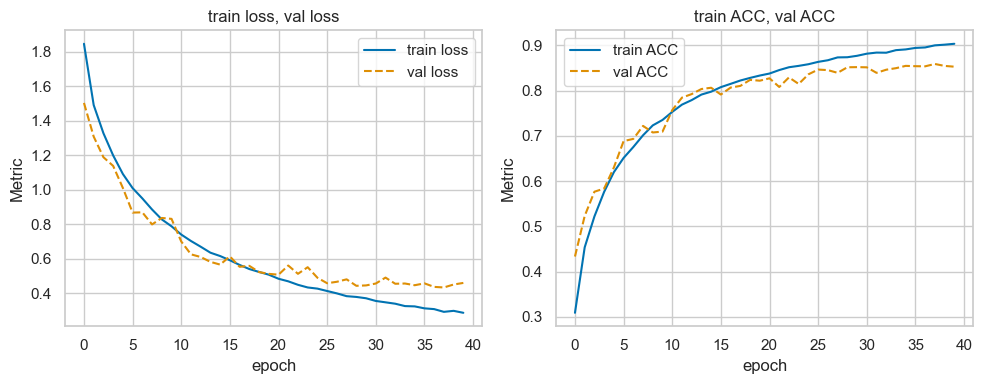

In [9]:
results = load_results('models/model_CIFAR10_DeeperCNN2.pt')

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # If the input and output dimensions differ, we need a projection to match the dimensions for residual connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Residual connection
        out = F.relu(out)
        return out

class ResNetLikeCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetLikeCNN, self).__init__()
        
        # Initial convolution layer
        self.conv = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(64)
        
        # Residual blocks
        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 128, stride=2)  # Downsample
        self.layer3 = ResidualBlock(128, 256, stride=2)  # Downsample
        self.layer4 = ResidualBlock(256, 512, stride=2)  # Downsample

        # Fully connected layer
        self.fc = nn.Linear(512 * 4 * 4, num_classes)

    def forward(self, x):
        out = F.relu(self.bn(self.conv(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out


In [12]:
model = ResNetLikeCNN()
summarizer(model, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
ResNetLikeCNN                            [64, 3, 32, 32]      [64, 10]             --
├─Conv2d: 1-1                            [64, 3, 32, 32]      [64, 64, 32, 32]     1,792
├─BatchNorm2d: 1-2                       [64, 64, 32, 32]     [64, 64, 32, 32]     128
├─ResidualBlock: 1-3                     [64, 64, 32, 32]     [64, 64, 32, 32]     --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]     [64, 64, 32, 32]     36,928
│    └─BatchNorm2d: 2-2                  [64, 64, 32, 32]     [64, 64, 32, 32]     128
│    └─Conv2d: 2-3                       [64, 64, 32, 32]     [64, 64, 32, 32]     36,928
│    └─BatchNorm2d: 2-4                  [64, 64, 32, 32]     [64, 64, 32, 32]     128
│    └─Identity: 2-5                     [64, 64, 32, 32]     [64, 64, 32, 32]     --
├─ResidualBlock: 1-4                     [64, 64, 32, 32]     [64, 128, 16, 16]    --
│    └─Conv2d: 2-6                 